In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/Users/eovito@ibm.com/Desktop/Content/Masterclass/CODE_BASE/bank-additional-full.csv',\
                 sep = ';')

df = df.drop(['duration', 'poutcome'], axis=1)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
X, y = df.loc[:, df.columns != 'y'], df['y'].map(dict(yes=1, no=0))

enc = OrdinalEncoder()
enc.fit(X)
X_en = enc.transform(X)
X_en = pd.DataFrame(X_en, columns = X.columns)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_en, y, test_size = 0.2)
#lets group different types
num_cols = [col for col in X_train.columns if np.issubdtype(X_train.dtypes[col], np.number)]
cat_cols = [col for col in X_train.columns if col not in num_cols]
print(num_cols, '\n',  cat_cols)

['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'] 
 ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week']


In [4]:
from sklearn.preprocessing import Normalizer as Norm
from sklearn.preprocessing import LabelEncoder as LabelEncoder
from sklearn.preprocessing import OneHotEncoder as OneHot
from sklearn.preprocessing import OrdinalEncoder as OrdinalEncoder
from lale.lib.lale import NoOp
import sklearn
import lale

#helper functions
from sklearn.compose import ColumnTransformer
from lale.operators import make_pipeline
from lale.pretty_print import ipython_display

#algorithms
from sklearn.linear_model import LogisticRegression as LR
from xgboost import XGBClassifier as XGBoost
# from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as Tree

lale.wrap_imported_operators()

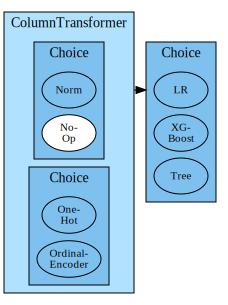

In [5]:
pipeline_planned = ColumnTransformer(transformers=[
        ('num_tfm', Norm | NoOp, num_cols),
        ('cat_tfm', OneHot | OrdinalEncoder, cat_cols)]) >> (
    LR | XGBoost | Tree)
pipeline_planned.visualize()

In [6]:
from lale.lib.lale import Hyperopt
#hyperopt natively uses Cross Validation
#THIS WILL FAIL OCCASSIONALLY, NEEDS TO BE REWORKED ON BACK END TO SEND SCHEMA, NON TRIVIAL
optimizer = Hyperopt(estimator=pipeline_planned, max_evals = 5, scoring='accuracy', verbose = True)
trained_optimizer = optimizer.fit(X_train, y_train)

100%|██████████| 5/5 [08:39<00:00, 103.95s/trial, best loss: -0.8960546282245827]


In [7]:
trained_optimizer.summary()

,tid,loss,time,log_loss,status
name,,,,,
p0,0,-0.882337,27.434032,0.358906,ok
p1,1,-0.886646,0.488381,0.353470,ok
p2,2,-0.886646,0.561293,0.353466,ok
p3,3,-0.896055,1.264311,0.974522,ok
p4,4,-0.860850,70.210839,0.685786,ok


In [8]:
best_estimator = trained_optimizer.summary().loss.argmin()
worst_estimator = trained_optimizer.summary().loss.argmax()
print(f'The best pipeline is {best_estimator} and the worst pipeline is {worst_estimator}')

The best pipeline is 3 and the worst pipeline is 4


In [32]:
import sklearn.metrics
predictions = trained_optimizer.predict(X_test)
print(f'accuracy {sklearn.metrics.accuracy_score(y_test, predictions):.1%}')
print(f'ROC {sklearn.metrics.roc_auc_score(y_test, predictions):.1%}')

accuracy 11.5%
ROC 50.0%


In [10]:
#this may end up being overkill but it shows that we can take Lale acc 
from sklearn.model_selection import cross_validate as cross_validate
cv_results = cross_validate(trained_optimizer,  X, y, cv=10,
                           scoring=('accuracy'))
sorted(cv_results.keys())

100%|██████████| 5/5 [00:00<?, ?trial/s, best loss=?]


['fit_time', 'score_time', 'test_score']

In [11]:
cv_results['test_score']

array([0.02767662, 0.03520272, 0.04224326, 0.06627822, 0.06239378,
       0.05462491, 0.10172372, 0.11968924, 0.15735794, 0.45944633])

In [12]:
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_results['test_score'].mean(), cv_results['test_score'].std()))


Accuracy: 0.11 (+/- 0.12)


In [23]:
###Second pipeline with explainable algorithms only
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import StandardScaler as SS

lale.wrap_imported_operators()

exp_pipe =SS >> (Norm | NoOp | PCA) >> (KNN | LR | Tree)
exp_pipe_trainable = Hyperopt(estimator = exp_pipe, max_evals = 5, scoring='accuracy', verbose = True)

In [24]:
#variables must be encoded before they are entered
exp_pipe_trained = exp_pipe_trainable.fit(X_train_e, y_train_e)

100%|██████████| 5/5 [00:53<00:00, 10.66s/trial, best loss: -0.8959028831562975]


In [25]:
exp_pipe_trained.summary()

,tid,loss,time,log_loss,status
name,,,,,
p0,0,-0.800637,1.277394,0.645044,ok
p1,1,-0.887314,0.215742,0.350510,ok
p2,2,-0.887314,0.348007,0.319841,ok
p3,3,-0.895903,4.260768,1.032003,ok
p4,4,-0.666980,0.297076,0.666688,ok


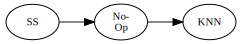

In [26]:
exp_pipe_trained.get_pipeline().visualize()

In [27]:
best_estimator1 = exp_pipe_trained.summary().loss.argmin()
worst_estimator1 = exp_pipe_trained.summary().loss.argmax()

In [28]:
print(f'The best pipeline is {best_estimator1} and the worst pipeline is {worst_estimator1}')

The best pipeline is 3 and the worst pipeline is 4


In [31]:
predictions2 = exp_pipe_trained.predict(X_test_e)
print(f'accuracy {sklearn.metrics.accuracy_score(y_test_e, predictions2):.1%}')
print(f'roc_accuracy {sklearn.metrics.roc_auc_score(y_test_e, predictions2):.1%}')

accuracy 89.9%
roc_accuracy 62.3%


In [33]:
import pickle as pkl

In [34]:
with open('trained_model.pkl', 'wb') as f:
    a = pkl.dumps(exp_pipe_trained)
    f.write(a)
    f.close